In [1]:
try:
    import fastkaggle
except:
    !pip install -U fastkaggle

from fastkaggle import *
api = import_kaggle()

from fastai.vision.all import *
from collections import defaultdict

In [2]:
comp = "classification-of-plants-of-southeast-asia"
path = setup_comp(comp)
path, path.ls()

(Path('classification-of-plants-of-southeast-asia'),
 (#3) [Path('classification-of-plants-of-southeast-asia/bali-26_train'),Path('classification-of-plants-of-southeast-asia/bali-26_test'),Path('classification-of-plants-of-southeast-asia/sample_submission.csv')])

In [3]:
trn_path = path/"bali-26_train"
tst_path = path/"bali-26_test"

In [4]:
max_size = 256
dest_path = Path("preproc")

def img_preproc(f):
    save_path = dest_path/f
    if save_path.exists():
        w, h = Image.open(save_path).size
        if w <= max_size and h <= max_size:
            return

    i = Image.open(f)
    w, h = i.size
    if w > max_size or h > max_size:
        if w > h:
            new_w = min(w, max_size)
            new_h = round(new_w / i.aspect)
        else:
            new_h = min(h, max_size)
            new_w = round(new_h * i.aspect)
        
        i = i.resize((new_w, new_h))
    
    save_path.parent.mkdir(exist_ok=True, parents=True)
    i.save(save_path)

from fastcore.parallel import *
parallel(img_preproc, get_image_files(path), chunksize=64, progress=True);
trn_files = get_image_files(dest_path/trn_path)
tst_files = get_image_files(dest_path/tst_path)

In [5]:
sizes = defaultdict(int)
aspects = defaultdict(int)

for f in trn_files+tst_files:
    i = Image.open(f)
    sizes[i.size] += 1
    aspects[i.aspect] += 1

print(sorted(sizes.items(), key=lambda x:x[1]))
print(sorted(aspects.items(), key=lambda x:x[1]))

[((144, 256), 16053), ((256, 144), 30178)]
[(0.5625, 16053), (1.7777777777777777, 30178)]


In [6]:
files_by_type = defaultdict(list)
xs = L()
ys = L()
for f in trn_files:
    xs.append(f)
    ys.append(f.parent.name)

In [24]:
_, idxs = TrainTestSplitter(test_size=0.3, stratify=ys)(xs)
xs_sub, ys_sub = xs[idxs], ys[idxs]
len(xs_sub)

12483

In [25]:
dls = DataBlock(blocks=(ImageBlock, CategoryBlock),
                get_y=parent_label,
                splitter=TrainTestSplitter(test_size=0.2, stratify=ys_sub),
                item_tfms=Resize(256, "pad", "zeros"),
                batch_tfms=aug_transforms(size=(128, 228), min_scale=0.75),
).dataloaders(xs_sub)

dls.train.n, dls.train.n//dls.train.bs, dls.train.drop_last

(9986, 156, True)

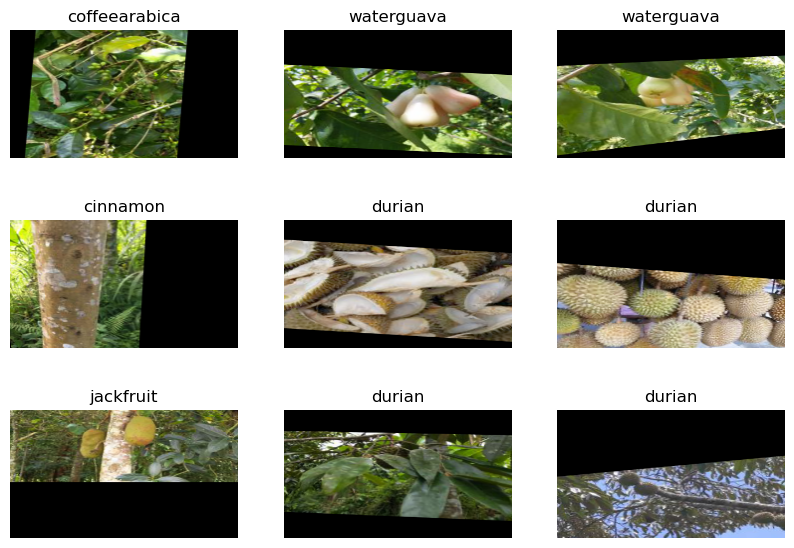

In [26]:
dls.show_batch(figsize=(10, 7))

In [27]:
learn = vision_learner(dls, 
                       "convnext_tiny.fb_in22k", 
                       metrics=error_rate, 
                       path=".").to_fp16()

SuggestedLRs(valley=0.013182567432522774, slide=0.05754399299621582)

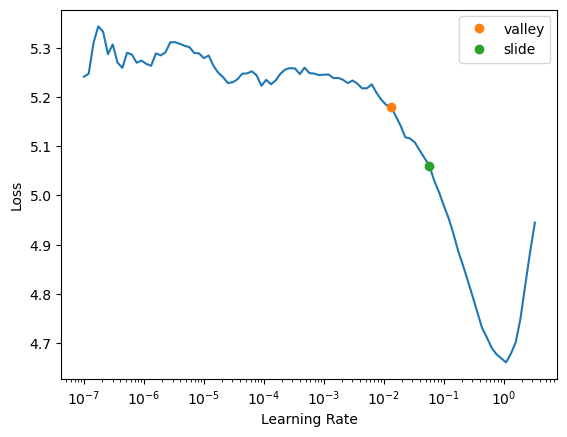

In [28]:
learn.lr_find(suggest_funcs=(valley, slide))

In [29]:
learn.fine_tune(5, 0.1)

epoch,train_loss,valid_loss,error_rate,time
0,1.534679,0.621528,0.177813,00:16


epoch,train_loss,valid_loss,error_rate,time
0,0.677169,0.317031,0.083700,00:22
1,0.577855,0.261730,0.076492,00:23
2,0.481492,0.208207,0.065278,00:22
3,0.424120,0.172871,0.053664,00:22
4,0.405082,0.168235,0.048859,00:22


In [30]:
tst_dl = dls.test_dl(tst_files)
probs,_,idxs = learn.get_preds(dl=tst_dl, with_decoded=True)
labels = dls.vocab[idxs]

In [31]:
df = pd.DataFrame({"id": [x.name for x in tst_files], "category": labels})
file_subm = f"subm_{comp}.csv"
df.to_csv(file_subm, index=False)
!head {file_subm}

id,category
1567.jpg,guava
4184.jpg,coffeearabica
3558.jpg,guava
1809.jpg,mangosteen
3579.jpg,dragonfruit
253.jpg,durian
3931.jpg,starfruit
706.jpg,sugarpalm
2211.jpg,starfruit


In [32]:
api.competition_submit_cli(file_subm, "10ep 0.0625data cnxt 228x128", comp)

100%|██████████| 78.2k/78.2k [00:01<00:00, 60.4kB/s]


Successfully submitted to Classification of plants of Southeast Asia

In [33]:
api.competition_submissions_cli(comp)

fileName                                             date                 description                   status    publicScore  privateScore  
---------------------------------------------------  -------------------  ----------------------------  --------  -----------  ------------  
subm_classification-of-plants-of-southeast-asia.csv  2023-06-30 08:06:41  10ep 0.0625data cnxt 228x128  complete  0.94117      0.95732       
subm_classification-of-plants-of-southeast-asia.csv  2023-06-30 07:28:06  10ep 0.0625data cnxt 228x128  complete  0.98183      0.98500       
subm_classification-of-plants-of-southeast-asia.csv  2023-06-30 06:42:19  10ep 0.05data cnxt 320x180    complete  0.98788      0.98644       
subm_classification-of-plants-of-southeast-asia.csv  2023-06-30 06:41:59  5ep more data cnxt 320x180    complete  0.98788      0.98644       
subm_classification-of-plants-of-southeast-asia.csv  2023-06-29 13:56:50  5ep more data cnxt 320x180    complete  0.99826      0.99826       
subm_c